# LDA-Based Taxonomy Tree for n8n Node Descriptions

這個 notebook 針對 n8n node descriptions 進行 LDA 分析：
1. 解析 descriptions/ 目錄中的 JSON 檔案
2. 提取功能描述、參數說明等語義內容
3. 透過 LDA 偵測出不同的功能類別
4. 建立基於功能語義的 taxonomy tree
5. 專注於 n8n nodes 的實際用途分類

In [11]:
import sys
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re

# 設定專案路徑
project_root = Path().absolute()
descriptions_path = project_root / "descriptions"

print(f"Project root: {project_root}")
print(f"Working directory: {Path().absolute()}")
print(f"Descriptions path: {descriptions_path}")

# 檢查 descriptions 目錄是否存在
if not descriptions_path.exists():
    print(f"Error: {descriptions_path} does not exist!")
else:
    desc_files = list(descriptions_path.glob("*_desc.json"))
    print(f"Found {len(desc_files)} description files")

Project root: /Users/yu/Desktop/projects/gss_cai/n8n_AI_Agent
Working directory: /Users/yu/Desktop/projects/gss_cai/n8n_AI_Agent
Descriptions path: /Users/yu/Desktop/projects/gss_cai/n8n_AI_Agent/descriptions
Found 435 description files


In [12]:
class NodeDescriptionParser:
    """解析 n8n node descriptions JSON 檔案"""
    
    def __init__(self, descriptions_dir):
        self.descriptions_dir = Path(descriptions_dir)
    
    def extract_semantic_content(self, desc_data):
        """提取語義內容，重點關注功能描述而非技術細節"""
        texts = []
        
        # 提取節點名稱
        if 'nodeName' in desc_data:
            texts.append(desc_data['nodeName'])
        
        # 提取功能摘要（最重要的部分）
        if 'summary' in desc_data:
            summary = desc_data['summary']
            # 重複添加 summary 以增加其權重
            texts.extend([summary] * 3)
        
        # 提取參數描述
        if 'parameters' in desc_data and isinstance(desc_data['parameters'], list):
            for param in desc_data['parameters']:
                if isinstance(param, dict):
                    # 參數名稱
                    if 'name' in param:
                        texts.append(param['name'])
                    
                    # 參數描述（重要）
                    if 'description' in param:
                        desc = param['description']
                        # 清理描述，移除技術性詞彙
                        clean_desc = self.clean_technical_terms(desc)
                        if clean_desc:
                            texts.append(clean_desc)
        
        # 提取範例內容（如果有的話）
        if 'example' in desc_data:
            example_text = self.extract_example_semantics(desc_data['example'])
            if example_text:
                texts.append(example_text)
        
        return texts
    
    def clean_technical_terms(self, text):
        """清理技術性詞彙，保留功能性描述"""
        if not text or len(text.strip()) < 3:
            return ""
        
        # 移除過於技術性的詞彙
        technical_patterns = [
            r'\bID\b', r'\bid\b', r'\bapi\b', r'\bAPI\b',
            r'\bjson\b', r'\bJSON\b', r'\bxml\b', r'\bXML\b',
            r'\bhttp\b', r'\bHTTP\b', r'\burl\b', r'\bURL\b',
            r'\bstring\b', r'\bboolean\b', r'\bnumber\b',
            r'要.*的.*ID', r'.*的.*ID', r'.*ID.*',
            r'是否.*', r'.*版本.*回應.*'
        ]
        
        cleaned = text
        for pattern in technical_patterns:
            cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE)
        
        # 保留有意義的內容
        cleaned = ' '.join(cleaned.split())
        return cleaned if len(cleaned) > 5 else ""
    
    def extract_example_semantics(self, example_data):
        """從範例中提取語義資訊"""
        texts = []
        
        def extract_values(data):
            if isinstance(data, dict):
                for key, value in data.items():
                    if isinstance(value, str) and not key.lower().endswith('id'):
                        # 只保留非ID的字串值
                        if len(value) > 2 and not value.isdigit():
                            texts.append(value)
                    elif isinstance(value, (dict, list)):
                        extract_values(value)
            elif isinstance(data, list):
                for item in data:
                    extract_values(item)
        
        extract_values(example_data)
        return ' '.join(texts)

    def clean_json_content(self, content):
        """清理JSON內容，移除trailing commas"""
        import re
        # 移除物件和陣列中的trailing commas
        content = re.sub(r',(\s*[}\]])', r'\1', content)
        return content
    
    def parse_description_file(self, file_path):
        """解析單一描述檔案"""
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()

            # 清理JSON內容
            cleaned_content = self.clean_json_content(content)
            desc_data = json.loads(cleaned_content)
            
            # 提取基本資訊
            node_name = desc_data.get('nodeName', file_path.stem.replace('_desc', ''))
            summary = desc_data.get('summary', '')
            
            # 提取語義內容
            semantic_texts = self.extract_semantic_content(desc_data)
            content = ' '.join(semantic_texts)
            
            # 從檔名推斷節點類型
            file_stem = file_path.stem.replace('_desc', '')
            node_type = self.infer_node_type(file_stem)
            
            return {
                'file_name': file_path.name,
                'file_path': str(file_path),
                'node_name': node_name,
                'summary': summary,
                'node_type': node_type,
                'content': content,
                'raw_data': desc_data
            }
        
        except Exception as e:
            print(f"Error parsing {file_path}: {e}")
            return None
    
    def infer_node_type(self, file_stem):
        """從檔名推斷節點類型"""
        if file_stem.endswith('Tool'):
            return 'tool'
        elif file_stem.endswith('Trigger'):
            return 'trigger'
        else:
            return 'regular'
    
    def parse_all_descriptions(self):
        """解析所有描述檔案"""
        descriptions = {}
        desc_files = list(self.descriptions_dir.glob("*_desc.json"))
        
        for file_path in desc_files:
            desc_info = self.parse_description_file(file_path)
            if desc_info:
                descriptions[desc_info['file_name']] = desc_info
        
        return descriptions

print("NodeDescriptionParser class created successfully!")

NodeDescriptionParser class created successfully!


In [13]:
class SemanticTopicModeler:
    """針對語義內容優化的 LDA Topic Modeling"""
    
    def __init__(self, n_topics=8, random_state=42):
        self.n_topics = n_topics
        self.random_state = random_state
        self.vectorizer = None
        self.lda_model = None
        self.feature_names = None
    
    def preprocess_text(self, text):
        """針對中英文混合的語義文字預處理"""
        # 保留中文、英文、數字和空格
        text = re.sub(r'[^\w\s\u4e00-\u9fff]', ' ', text)
        # 移除純數字的詞
        text = re.sub(r'\b\d+\b', '', text)
        # 轉小寫（只影響英文）
        text = text.lower()
        # 移除多餘空白
        text = ' '.join(text.split())
        return text
    
    def create_custom_stop_words(self):
        """創建自定義停用詞列表"""
        english_stops = [
            'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
            'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
            'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
            'should', 'may', 'might', 'can', 'this', 'that', 'these', 'those'
        ]
        
        # 技術性停用詞
        technical_stops = [
            'id', 'api', 'json', 'xml', 'http', 'url', 'string', 'boolean', 'number',
            'field', 'fields', 'value', 'values', 'data', 'type', 'name', 'operation',
            'resource', 'response', 'request', 'parameter', 'parameters', 'option', 'options',
            'node', 'workflow', 'n8n', 'tool', 'trigger'
        ]
        
        # 中文停用詞
        chinese_stops = [
            '的', '了', '在', '是', '我', '有', '和', '就', '不', '人', '都', '一', '一個',
            '上', '也', '很', '到', '說', '要', '去', '你', '會', '著', '沒有', '看', '好',
            '自己', '這', '個', '們', '來', '為', '與', '或', '但', '如果', '這個', '那個',
            '可以', '能夠', '進行', '執行', '使用', '設定', '設置', '配置', '選擇', '選項'
        ]
        
        return english_stops + technical_stops + chinese_stops
    
    def fit_transform(self, documents):
        """執行語義導向的 LDA 分析"""
        # 預處理文件
        processed_docs = [self.preprocess_text(doc) for doc in documents]
        
        # 移除空文件
        processed_docs = [doc for doc in processed_docs if len(doc.strip()) > 10]
        
        # 使用自定義停用詞
        custom_stop_words = self.create_custom_stop_words()
        
        # 配置向量化器，針對語義內容優化
        self.vectorizer = CountVectorizer(
            max_features=500,  # 減少特徵數，聚焦主要詞彙
            min_df=2,  # 至少出現在2個文件中
            max_df=0.7,  # 不超過70%的文件包含
            stop_words=custom_stop_words,
            ngram_range=(1, 2),  # 包含單詞和雙詞組合
            token_pattern=r'\b[\w\u4e00-\u9fff]{2,}\b'  # 支持中文
        )
        
        doc_term_matrix = self.vectorizer.fit_transform(processed_docs)
        self.feature_names = self.vectorizer.get_feature_names_out()
        
        # LDA 配置
        self.lda_model = LatentDirichletAllocation(
            n_components=self.n_topics,
            random_state=self.random_state,
            max_iter=20,  # 增加迭代次數
            learning_method='online',
            doc_topic_prior=0.1,  # 較低的先驗，鼓勵文件專注於少數主題
            topic_word_prior=0.01  # 較低的先驗，鼓勵主題專注於少數詞彙
        )
        
        doc_topic_probs = self.lda_model.fit_transform(doc_term_matrix)
        perplexity = self.lda_model.perplexity(doc_term_matrix)
        
        # 生成結果
        results = self._generate_results(doc_topic_probs)
        results['model_perplexity'] = perplexity
        results['processed_docs_count'] = len(processed_docs)
        
        return results
    
    def _generate_results(self, doc_topic_probs):
        """生成語義分析結果"""
        results = {
            'topics': [],
            'document_topics': [],
            'topic_similarities': []
        }
        
        # 生成 topics 資訊
        for topic_idx in range(self.n_topics):
            topic_words = []
            topic_weights = self.lda_model.components_[topic_idx]
            top_indices = topic_weights.argsort()[-15:][::-1]  # 取更多詞彙
            
            for idx in top_indices:
                topic_words.append({
                    'word': self.feature_names[idx],
                    'weight': float(topic_weights[idx])
                })
            
            # 生成更語義化的標籤
            label = self._generate_semantic_label(topic_words)
            coherence = np.mean([w['weight'] for w in topic_words[:5]])
            
            results['topics'].append({
                'id': topic_idx,
                'label': label,
                'top_words': topic_words,
                'coherence': float(coherence)
            })
        
        # 生成文件-主題對應
        for doc_idx, topic_probs in enumerate(doc_topic_probs):
            dominant_topic = int(np.argmax(topic_probs))
            dominant_prob = float(np.max(topic_probs))
            
            results['document_topics'].append({
                'document_index': doc_idx,
                'dominant_topic': dominant_topic,
                'dominant_topic_probability': dominant_prob,
                'all_topic_probabilities': topic_probs.tolist()
            })
        
        # 計算主題相似性
        topic_similarities = np.corrcoef(self.lda_model.components_)
        results['topic_similarities'] = topic_similarities.tolist()
        
        return results
    
    def _generate_semantic_label(self, topic_words):
        """基於詞彙語義生成主題標籤"""
        # 優先選擇更有語義意義的詞彙
        semantic_words = []
        functional_words = []
        
        for word_info in topic_words[:10]:
            word = word_info['word']
            # 判斷是否為功能性詞彙
            if self._is_functional_word(word):
                functional_words.append(word)
            else:
                semantic_words.append(word)
        
        # 優先使用功能性詞彙，否則使用語義詞彙
        if functional_words:
            label_words = functional_words[:2]
        else:
            label_words = semantic_words[:2]
        
        if not label_words:
            label_words = [topic_words[0]['word'], topic_words[1]['word']]
        
        return ' + '.join(label_words).title()
    
    def _is_functional_word(self, word):
        """判斷是否為功能性詞彙"""
        functional_indicators = [
            '管理', '創建', '發送', '獲取', '更新', '刪除', '查詢', '搜索', '分析',
            '郵件', '消息', '訊息', '文件', '數據', '資料', '客戶', '用戶', '聯繫',
            'email', 'message', 'file', 'data', 'customer', 'user', 'contact',
            'manage', 'create', 'send', 'get', 'update', 'delete', 'search', 'analyze',
            'calendar', 'task', 'project', 'database', 'chat', 'social', 'payment'
        ]
        
        return any(indicator in word.lower() for indicator in functional_indicators)

print("SemanticTopicModeler class created successfully!")

SemanticTopicModeler class created successfully!


## Step 1: 載入和解析 Node Description 檔案

In [14]:
# 解析 Node Description 檔案
parser = NodeDescriptionParser(descriptions_path)
descriptions = parser.parse_all_descriptions()

print(f"Successfully parsed {len(descriptions)} description files")
print(f"First few files: {list(descriptions.keys())[:5]}")

# 顯示範例描述內容
if descriptions:
    first_desc = next(iter(descriptions.values()))
    print(f"\nExample description: {first_desc['file_name']}")
    print(f"Node name: {first_desc['node_name']}")
    print(f"Summary: {first_desc['summary'][:100]}...")
    print(f"Content length: {len(first_desc['content'])} characters")
    print(f"Node type: {first_desc['node_type']}")
    
# 統計節點類型分佈
node_types = Counter([desc['node_type'] for desc in descriptions.values()])
print(f"\nNode type distribution:")
for node_type, count in node_types.items():
    print(f"  {node_type}: {count}")

Error parsing /Users/yu/Desktop/projects/gss_cai/n8n_AI_Agent/descriptions/scheduleTrigger_desc.json: Expecting value: line 146 column 13 (char 3538)
Successfully parsed 434 description files
First few files: ['rssFeedRead_desc.json', 'sendInBlue_desc.json', 'microsoftSharePoint_desc.json', 'simulateTrigger_desc.json', 'stackby_desc.json']

Example description: rssFeedRead_desc.json
Node name: rss read
Summary: 此節點從 RSS Feed 中讀取數據。...
Content length: 133 characters
Node type: regular

Node type distribution:
  regular: 333
  trigger: 101


## Step 2: 準備語義內容進行 LDA 分析

In [15]:
# 準備語義內容
documents = []
file_mapping = []

for file_name, desc_data in descriptions.items():
    content = desc_data["content"]
    summary = desc_data["summary"]
    
    # 過濾掉內容太少的檔案
    if len(content.strip()) > 20 and len(summary.strip()) > 10:
        documents.append(content)
        file_mapping.append({
            "file_path": desc_data["file_path"],
            "file_name": desc_data["file_name"],
            "node_name": desc_data["node_name"],
            "summary": desc_data["summary"],
            "node_type": desc_data["node_type"]
        })

print(f"Prepared {len(documents)} documents for semantic LDA analysis")

content_lengths = [len(doc) for doc in documents]
print(f"Content length - Min: {min(content_lengths)}, Max: {max(content_lengths)}, Mean: {np.mean(content_lengths):.0f}")

# 顯示內容範例
if documents:
    print(f"\nExample semantic content:")
    print(f"File: {file_mapping[0]['file_name']}")
    print(f"Summary: {file_mapping[0]['summary']}")
    print(f"Content preview: {documents[0][:200]}...")

Prepared 431 documents for semantic LDA analysis
Content length - Min: 75, Max: 1930, Mean: 393

Example semantic content:
File: rssFeedRead_desc.json
Summary: 此節點從 RSS Feed 中讀取數據。
Content preview: rss read 此節點從 RSS Feed 中讀取數據。 此節點從 RSS Feed 中讀取數據。 此節點從 RSS Feed 中讀取數據。 url RSS feed 的 。 options 其他選項設定。 https://example.com/rss-feed...


## Step 3: 執行語義導向的 LDA Topic Modeling

In [16]:
# 執行語義 LDA
semantic_modeler = SemanticTopicModeler(n_topics=8)  # 減少主題數，提高分類質量
lda_results = semantic_modeler.fit_transform(documents)

print(f"Semantic LDA analysis completed!")
print(f"Generated {len(lda_results['topics'])} topics")
print(f"Processed {lda_results['processed_docs_count']} documents")
print(f"Model perplexity: {lda_results.get('model_perplexity', 'N/A'):.2f}")

Semantic LDA analysis completed!
Generated 8 topics
Processed 431 documents
Model perplexity: 248.05


## Step 4: 顯示語義 Topics 和對應的節點

In [17]:
def display_semantic_topic_details(topic_id, min_probability=0.15):
    """顯示語義主題的詳細資訊"""
    topic_info = lda_results['topics'][topic_id]
    
    print(f"\n🎯 === Topic {topic_id}: {topic_info['label']} ===")
    print(f"Coherence Score: {topic_info['coherence']:.3f}")
    
    # 顯示關鍵詞
    print("\n🔑 Key Words:")
    for word_info in topic_info['top_words'][:12]:
        print(f"  {word_info['word']: <20} {word_info['weight']:.4f}")
    
    # 找出屬於這個主題的節點
    topic_nodes = []
    for doc_idx, doc_topic in enumerate(lda_results['document_topics']):
        if doc_topic['dominant_topic'] == topic_id and doc_topic['dominant_topic_probability'] >= min_probability:
            node_info = file_mapping[doc_idx]
            topic_nodes.append({
                **node_info,
                'probability': doc_topic['dominant_topic_probability']
            })
    
    # 按機率排序
    topic_nodes.sort(key=lambda x: x['probability'], reverse=True)
    
    print(f"\n📦 Nodes in this topic ({len(topic_nodes)} nodes with prob >= {min_probability}):")
    
    # 按節點類型分組顯示
    node_types = defaultdict(list)
    for node in topic_nodes:
        node_types[node['node_type']].append(node)
    
    for node_type, nodes in node_types.items():
        print(f"\n  📂 {node_type.upper()} nodes ({len(nodes)}):")
        for node_info in nodes[:8]:  # 每類最多顯示8個
            node_name = node_info['node_name'].replace('_desc', '').replace('.json', '')
            print(f"    • {node_name: <25} ({node_info['probability']:.3f}) - {node_info['summary'][:60]}...")
        
        if len(nodes) > 8:
            print(f"    ... and {len(nodes) - 8} more {node_type} nodes")
    
    return topic_nodes

# 顯示所有語義主題
all_semantic_topics = {}
for i in range(len(lda_results['topics'])):
    topic_nodes = display_semantic_topic_details(i)
    all_semantic_topics[i] = topic_nodes


🎯 === Topic 0: 透過 + 事件 ===
Coherence Score: 89.918

🔑 Key Words:
  透過                   124.6244
  事件                   88.7019
  處理                   86.2471
  webhooks             75.4888
  webhooks 處理          74.5284
  透過 webhooks          68.8824
  事件 透過                44.3548
  form                 39.1843
  webhook              37.3490
  io                   27.1313
  從列表中選擇               24.4145
  google               23.5560

📦 Nodes in this topic (63 nodes with prob >= 0.15):

  📂 TRIGGER nodes (52):
    • formIoTrigger             (0.990) - 透過 Webhooks 處理 form.io 事件...
    • netlifyTrigger            (0.989) - 透過 Webhooks 處理 Netlify 事件。...
    • activeCampaignTrigger     (0.984) - 透過 Webhooks 處理 ActiveCampaign 事件。...
    • wise trigger              (0.983) - 透過 Webhooks 處理 Wise 事件...
    • jotform trigger           (0.983) - 透過 Webhooks 處理 JotForm 事件...
    • payPalTrigger             (0.983) - 透過 Webhooks 處理 PayPal 事件。...
    • wufooTrigger              (0.983) - 透過 Webhoo

## Step 5: 分析 Topic 品質和分佈


📊 === Semantic Topic Distribution Statistics ===
 topic_id               label  nodes_count  avg_probability  coherence                            top_words  regular_nodes  tool_nodes  trigger_nodes
        4         Create + 刪除          142         0.802772 119.794293         此節點用於消費, create, 此節點用於使用, 刪除            140           0              2
        1        Create + Get           74         0.830325 109.201742 perform, consume, select, operations             63           0             11
        0             透過 + 事件           63         0.815481  89.918098                 透過, 事件, 處理, webhooks             11           0             52
        5      File + Message           52         0.722155  54.768723             html, file, example, com             50           0              2
        7 將數據發送到 + 將數據發送到 Aws           34         0.739505  22.470280     aws, events, 將數據發送到, certificate             23           0             11
        6 事件發生時啟動工作流程 + Topic           31        

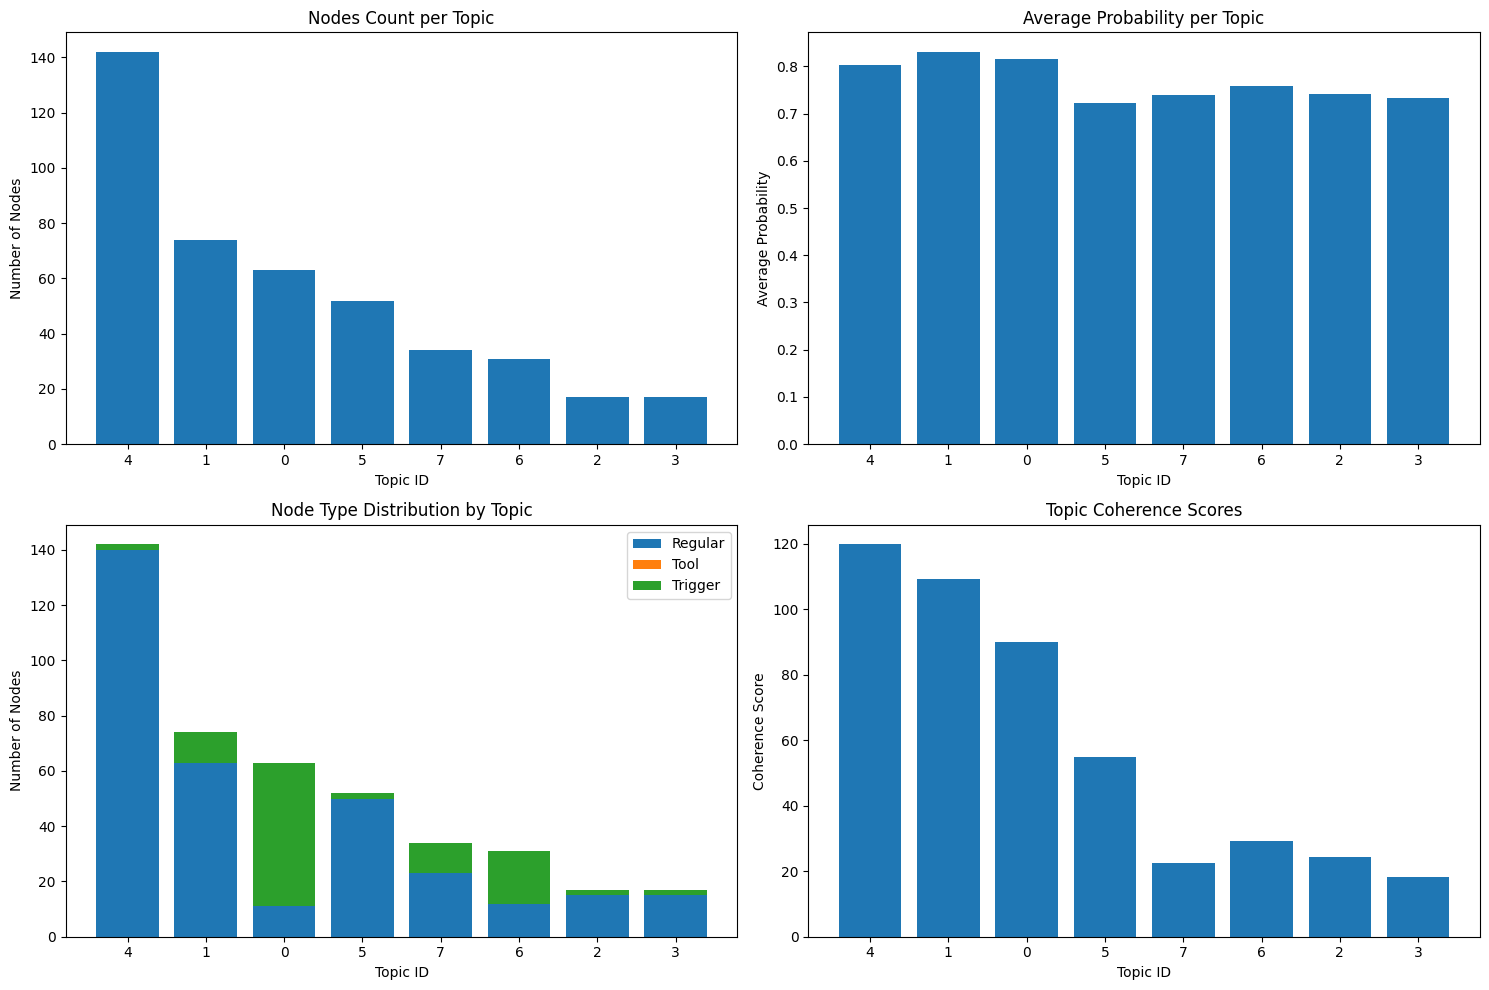


📈 === Classification Summary ===
Total documents: 431
Classified documents: 430
Classification rate: 99.8%
Average nodes per topic: 53.8


In [18]:
# 統計每個主題的節點數量和品質
topic_stats = []
for topic_id, topic_info in enumerate(lda_results['topics']):
    nodes_count = len(all_semantic_topics[topic_id])
    avg_prob = np.mean([n['probability'] for n in all_semantic_topics[topic_id]]) if nodes_count > 0 else 0
    
    # 統計節點類型分佈
    type_dist = Counter([n['node_type'] for n in all_semantic_topics[topic_id]])
    
    topic_stats.append({
        'topic_id': topic_id,
        'label': topic_info['label'],
        'nodes_count': nodes_count,
        'avg_probability': avg_prob,
        'coherence': topic_info['coherence'],
        'top_words': ', '.join([w['word'] for w in topic_info['top_words'][:4]]),
        'regular_nodes': type_dist.get('regular', 0),
        'tool_nodes': type_dist.get('tool', 0),
        'trigger_nodes': type_dist.get('trigger', 0)
    })

# 轉換為 DataFrame 並顯示
df_stats = pd.DataFrame(topic_stats)
df_stats = df_stats.sort_values('nodes_count', ascending=False)

print("\n📊 === Semantic Topic Distribution Statistics ===")
print(df_stats.to_string(index=False))

# 視覺化主題分佈
plt.figure(figsize=(15, 10))

# 1. 節點數量分佈
plt.subplot(2, 2, 1)
plt.bar(range(len(df_stats)), df_stats['nodes_count'])
plt.xlabel('Topic ID')
plt.ylabel('Number of Nodes')
plt.title('Nodes Count per Topic')
plt.xticks(range(len(df_stats)), df_stats['topic_id'])

# 2. 平均機率
plt.subplot(2, 2, 2)
plt.bar(range(len(df_stats)), df_stats['avg_probability'])
plt.xlabel('Topic ID')
plt.ylabel('Average Probability')
plt.title('Average Probability per Topic')
plt.xticks(range(len(df_stats)), df_stats['topic_id'])

# 3. 節點類型分佈堆疊圖
plt.subplot(2, 2, 3)
width = 0.8
p1 = plt.bar(range(len(df_stats)), df_stats['regular_nodes'], width, label='Regular')
p2 = plt.bar(range(len(df_stats)), df_stats['tool_nodes'], width, bottom=df_stats['regular_nodes'], label='Tool')
p3 = plt.bar(range(len(df_stats)), df_stats['trigger_nodes'], width, 
             bottom=df_stats['regular_nodes'] + df_stats['tool_nodes'], label='Trigger')
plt.xlabel('Topic ID')
plt.ylabel('Number of Nodes')
plt.title('Node Type Distribution by Topic')
plt.xticks(range(len(df_stats)), df_stats['topic_id'])
plt.legend()

# 4. Coherence scores
plt.subplot(2, 2, 4)
plt.bar(range(len(df_stats)), df_stats['coherence'])
plt.xlabel('Topic ID')
plt.ylabel('Coherence Score')
plt.title('Topic Coherence Scores')
plt.xticks(range(len(df_stats)), df_stats['topic_id'])

plt.tight_layout()
plt.show()

# 總結統計
total_classified = sum(df_stats['nodes_count'])
total_documents = len(file_mapping)
classification_rate = (total_classified / total_documents) * 100

print(f"\n📈 === Classification Summary ===")
print(f"Total documents: {total_documents}")
print(f"Classified documents: {total_classified}")
print(f"Classification rate: {classification_rate:.1f}%")
print(f"Average nodes per topic: {total_classified / len(lda_results['topics']):.1f}")

## Step 6: 建立語義 Taxonomy Tree

In [19]:
class SemanticTaxonomyBuilder:
    """基於語義分析建立 Taxonomy Tree"""
    
    def __init__(self, lda_results, file_mapping, min_probability=0.15):
        self.lda_results = lda_results
        self.file_mapping = file_mapping
        self.min_probability = min_probability
        self.taxonomy_tree = {}
    
    def build_taxonomy(self):
        """建立基於語義的 taxonomy tree"""
        self.taxonomy_tree = {
            "metadata": {
                "method": "Semantic_LDA_Based_Taxonomy",
                "data_source": "n8n_node_descriptions",
                "n_topics": len(self.lda_results['topics']),
                "min_probability": self.min_probability,
                "total_files": len(self.file_mapping),
                "model_perplexity": self.lda_results.get('model_perplexity', 'N/A'),
                "analysis_focus": "functional_semantics"
            },
            "functional_categories": {},
            "unclassified": {
                "nodes": [],
                "description": "Nodes that don't meet the minimum probability threshold"
            },
            "statistics": {}
        }
        
        classified_files = set()
        
        # 為每個語義主題建立功能分類
        for topic_id, topic_info in enumerate(self.lda_results['topics']):
            category_key = f"category_{topic_id}"
            topic_nodes = []
            
            for doc_idx, doc_topic in enumerate(self.lda_results['document_topics']):
                if (doc_topic['dominant_topic'] == topic_id and 
                    doc_topic['dominant_topic_probability'] >= self.min_probability):
                    
                    file_info = self.file_mapping[doc_idx]
                    topic_nodes.append({
                        "file_path": file_info['file_path'],
                        "file_name": file_info['file_name'],
                        "node_name": file_info['node_name'],
                        "summary": file_info['summary'],
                        "node_type": file_info['node_type'],
                        "probability": doc_topic['dominant_topic_probability'],
                        "topic_distribution": doc_topic['all_topic_probabilities']
                    })
                    
                    classified_files.add(doc_idx)
            
            # 按機率和類型排序
            topic_nodes.sort(key=lambda x: (x['node_type'], -x['probability']))
            
            # 統計節點類型
            type_stats = Counter([node['node_type'] for node in topic_nodes])
            
            # 建立功能分類
            self.taxonomy_tree["functional_categories"][category_key] = {
                "category_id": topic_id,
                "label": topic_info['label'],
                "description": self._generate_category_description(topic_info, type_stats),
                "nodes": topic_nodes,
                "semantic_keywords": [w['word'] for w in topic_info['top_words'][:8]],
                "coherence": topic_info['coherence'],
                "node_count": len(topic_nodes),
                "avg_probability": np.mean([n['probability'] for n in topic_nodes]) if topic_nodes else 0,
                "node_type_distribution": dict(type_stats),
                "functional_focus": self._identify_functional_focus(topic_info['top_words'])
            }
        
        # 處理未分類的節點
        unclassified_nodes = []
        for doc_idx, file_info in enumerate(self.file_mapping):
            if doc_idx not in classified_files:
                doc_topic = self.lda_results['document_topics'][doc_idx]
                unclassified_nodes.append({
                    "file_path": file_info['file_path'],
                    "file_name": file_info['file_name'],
                    "node_name": file_info['node_name'],
                    "summary": file_info['summary'],
                    "node_type": file_info['node_type'],
                    "max_probability": max(doc_topic['all_topic_probabilities']),
                    "likely_category": doc_topic['dominant_topic'],
                    "reason": "Below minimum probability threshold"
                })
        
        self.taxonomy_tree["unclassified"]["nodes"] = unclassified_nodes
        self._generate_statistics()
        
        return self.taxonomy_tree
    
    def _generate_category_description(self, topic_info, type_stats):
        """生成功能分類描述"""
        main_function = topic_info['label']
        top_words = [w['word'] for w in topic_info['top_words'][:5]]
        
        desc_parts = [f"Nodes focused on {main_function.lower()}"]
        
        if type_stats:
            type_info = ', '.join([f"{count} {t}" for t, count in type_stats.most_common(2)])
            desc_parts.append(f"Includes {type_info} nodes")
        
        desc_parts.append(f"Key concepts: {', '.join(top_words)}")
        
        return '. '.join(desc_parts)
    
    def _identify_functional_focus(self, top_words):
        """識別功能重點"""
        functional_patterns = {
            'communication': ['郵件', 'email', 'message', 'chat', 'notification', '通知', '消息'],
            'data_management': ['數據', 'data', 'database', '資料', 'storage', '存儲'],
            'automation': ['自動', 'auto', 'schedule', '定時', 'trigger', '觸發'],
            'integration': ['api', '整合', 'connect', '連接', 'sync', '同步'],
            'analysis': ['分析', 'analyze', 'report', '報告', 'statistics', '統計'],
            'file_handling': ['文件', 'file', 'document', '檔案', 'upload', 'download'],
            'customer_management': ['客戶', 'customer', 'contact', '聯繫', 'crm'],
            'project_management': ['項目', 'project', 'task', '任務', 'workflow', '工作流']
        }
        
        word_list = [w['word'].lower() for w in top_words[:10]]
        
        for focus, patterns in functional_patterns.items():
            if any(pattern in ' '.join(word_list) for pattern in patterns):
                return focus
        
        return 'general'
    
    def _generate_statistics(self):
        """生成分類統計資訊"""
        total_files = len(self.file_mapping)
        classified_files = sum(cat['node_count'] for cat in self.taxonomy_tree['functional_categories'].values())
        unclassified_files = len(self.taxonomy_tree['unclassified']['nodes'])
        
        # 統計功能重點分佈
        functional_focus_dist = Counter([
            cat['functional_focus'] 
            for cat in self.taxonomy_tree['functional_categories'].values()
        ])
        
        self.taxonomy_tree['statistics'] = {
            "total_files": total_files,
            "classified_files": classified_files,
            "unclassified_files": unclassified_files,
            "classification_rate": (classified_files / total_files) * 100,
            "categories_count": len(self.taxonomy_tree['functional_categories']),
            "avg_nodes_per_category": classified_files / len(self.taxonomy_tree['functional_categories']) if self.taxonomy_tree['functional_categories'] else 0,
            "functional_focus_distribution": dict(functional_focus_dist)
        }

# 建立語義 taxonomy
semantic_taxonomy_builder = SemanticTaxonomyBuilder(lda_results, file_mapping, min_probability=0.15)
semantic_taxonomy = semantic_taxonomy_builder.build_taxonomy()

print("Semantic-Based Taxonomy Tree created successfully!")
print(f"\n📊 Classification Statistics:")
for key, value in semantic_taxonomy['statistics'].items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2f}")
    elif isinstance(value, dict):
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: {value}")

Semantic-Based Taxonomy Tree created successfully!

📊 Classification Statistics:
  total_files: 431
  classified_files: 430
  unclassified_files: 1
  classification_rate: 99.77
  categories_count: 8
  avg_nodes_per_category: 53.75
  functional_focus_distribution: {'general': 5, 'communication': 1, 'customer_management': 1, 'data_management': 1}


## Step 7: 匯出語義分析結果

In [20]:
# 匯出語義分析結果
output_dir = project_root / "data" / "output" / "semantic_analysis"
output_dir.mkdir(parents=True, exist_ok=True)

def make_json_serializable(obj):
    """JSON 序列化處理"""
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_serializable(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (bool, int, float, str)) or obj is None:
        return obj
    else:
        return str(obj)

final_taxonomy = make_json_serializable(semantic_taxonomy)

# 1. 匯出完整的語義 taxonomy tree
semantic_output_path = output_dir / "n8n_semantic_taxonomy_tree.json"
with open(semantic_output_path, 'w', encoding='utf-8') as f:
    json.dump(final_taxonomy, f, ensure_ascii=False, indent=2)

print(f"✅ Semantic taxonomy tree exported to: {semantic_output_path}")

# 2. 匯出功能分類摘要
functional_summary = {
    "analysis_method": "Semantic LDA on Node Descriptions",
    "summary": final_taxonomy['statistics'],
    "functional_categories": {
        cat_key: {
            "label": cat_data['label'],
            "description": cat_data['description'],
            "node_count": cat_data['node_count'],
            "functional_focus": cat_data['functional_focus'],
            "semantic_keywords": cat_data['semantic_keywords'][:6],
            "top_nodes": [
                {
                    "name": node['node_name'],
                    "type": node['node_type'],
                    "summary": node['summary'][:80] + "..." if len(node['summary']) > 80 else node['summary'],
                    "probability": node['probability']
                }
                for node in cat_data['nodes'][:5]
            ]
        }
        for cat_key, cat_data in final_taxonomy['functional_categories'].items()
    }
}

summary_output_path = output_dir / "n8n_functional_categories_summary.json"
with open(summary_output_path, 'w', encoding='utf-8') as f:
    json.dump(functional_summary, f, ensure_ascii=False, indent=2)

print(f"📋 Functional categories summary exported to: {summary_output_path}")

# 3. 匯出 CSV 格式的節點分類對應表
category_mapping = []
for cat_key, cat_data in final_taxonomy['functional_categories'].items():
    for node in cat_data['nodes']:
        category_mapping.append({
            'category_id': cat_data['category_id'],
            'category_label': cat_data['label'],
            'functional_focus': cat_data['functional_focus'],
            'node_name': node['node_name'],
            'node_type': node['node_type'],
            'summary': node['summary'],
            'probability': node['probability']
        })

df_mapping = pd.DataFrame(category_mapping)
csv_output_path = output_dir / "n8n_semantic_node_categories.csv"
df_mapping.to_csv(csv_output_path, index=False, encoding='utf-8')
print(f"📊 Node category mapping exported to: {csv_output_path}")

# 4. 生成分析報告
analysis_report = {
    "analysis_date": "2024-09-19",
    "method": "Semantic LDA Analysis on n8n Node Descriptions",
    "data_source": "descriptions/*.json files",
    "key_improvements": [
        "Focused on functional semantics rather than technical schemas",
        "Used Chinese and English description content",
        "Applied semantic preprocessing to filter technical noise",
        "Generated function-oriented topic labels",
        "Categorized nodes by actual use cases and purposes"
    ],
    "statistics": final_taxonomy['statistics'],
    "functional_categories": [
        {
            "category_id": cat_data['category_id'],
            "label": cat_data['label'],
            "functional_focus": cat_data['functional_focus'],
            "node_count": cat_data['node_count'],
            "avg_probability": cat_data['avg_probability'],
            "coherence": cat_data['coherence'],
            "semantic_keywords": cat_data['semantic_keywords'][:5]
        }
        for cat_data in final_taxonomy['functional_categories'].values()
    ]
}

report_output_path = output_dir / "semantic_analysis_report.json"
with open(report_output_path, 'w', encoding='utf-8') as f:
    json.dump(analysis_report, f, ensure_ascii=False, indent=2)

print(f"📈 Analysis report exported to: {report_output_path}")

print(f"\n🎉 === Semantic Analysis Complete! ===")
print(f"📊 Generated {final_taxonomy['statistics']['categories_count']} functional categories")
print(f"📦 Classified {final_taxonomy['statistics']['classified_files']}/{final_taxonomy['statistics']['total_files']} nodes ({final_taxonomy['statistics']['classification_rate']:.1f}%)")
print(f"🎯 Average nodes per category: {final_taxonomy['statistics']['avg_nodes_per_category']:.1f}")
print(f"🔍 Functional focus distribution: {final_taxonomy['statistics']['functional_focus_distribution']}")

print(f"\n📁 Output files structure:")
print(f"   data/output/semantic_analysis/")
print(f"   ├── n8n_semantic_taxonomy_tree.json")
print(f"   ├── n8n_functional_categories_summary.json")
print(f"   ├── n8n_semantic_node_categories.csv")
print(f"   └── semantic_analysis_report.json")

✅ Semantic taxonomy tree exported to: /Users/yu/Desktop/projects/gss_cai/n8n_AI_Agent/data/output/semantic_analysis/n8n_semantic_taxonomy_tree.json
📋 Functional categories summary exported to: /Users/yu/Desktop/projects/gss_cai/n8n_AI_Agent/data/output/semantic_analysis/n8n_functional_categories_summary.json
📊 Node category mapping exported to: /Users/yu/Desktop/projects/gss_cai/n8n_AI_Agent/data/output/semantic_analysis/n8n_semantic_node_categories.csv
📈 Analysis report exported to: /Users/yu/Desktop/projects/gss_cai/n8n_AI_Agent/data/output/semantic_analysis/semantic_analysis_report.json

🎉 === Semantic Analysis Complete! ===
📊 Generated 8 functional categories
📦 Classified 430/431 nodes (99.8%)
🎯 Average nodes per category: 53.8
🔍 Functional focus distribution: {'general': 5, 'communication': 1, 'customer_management': 1, 'data_management': 1}

📁 Output files structure:
   data/output/semantic_analysis/
   ├── n8n_semantic_taxonomy_tree.json
   ├── n8n_functional_categories_summary.j